# Active Session 3: Clustering

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cihan-ates/data-driven-engineering/blob/master/DDE_I_ML_Dynamical_Systems/Lecture%205/Lecture_3.ipynb)


# Important Note

Lecture notes and notebooks must not be copied and/or distributed without the explicit written permission from ITS.





# 1. Problem Definition: Probe into the Data

In this dataset, we will be looking into manufacturing error analysis. The dataset includes modified sensory inputs collected on the manufacturing line and we will be using this multi-dimensional input data to predict the defective products via clustering this sensory input. 

Note that the data set includes over 280,000 instances, where only a small fraction (~500) of products are defective. 



# 2. Preparing the enviroment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [ ]:
# numpy upgrade is needed for one of the models:
!pip3 install --upgrade numpy

In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 199 µs (started: 2021-11-25 08:12:33 +00:00)


In [ ]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
import os
import io
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

time: 3.04 ms (started: 2021-11-25 08:58:25 +00:00)


In [ ]:
# Data Preparation
# Data Preparation
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report


time: 53.9 ms (started: 2021-11-25 08:12:33 +00:00)


In [ ]:
# ML Algorithms to be used
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.mixture import BayesianGaussianMixture

time: 117 ms (started: 2021-11-25 08:12:33 +00:00)


# 3. Pre-processing


## Loading the Data

We need to upload the dataset to Colab enviroment. In general, Pandas library is a practical way to fetch the data from an url. However, the data we would be using today is on ILIAS and hence you need to upload the data from your local pc / Google Drive. 

In [ ]:
#Lets see what is present in the directory:
!ls

adc.json  manufacturing.csv  sample_data
time: 131 ms (started: 2021-11-25 08:12:33 +00:00)


In [ ]:
# Loading the data

#Local drive:
#from google.colab import files
#uploaded = files.upload()

time: 1.81 ms (started: 2021-11-25 08:12:34 +00:00)


In [ ]:
#!ls

time: 1.31 ms (started: 2021-11-25 08:12:34 +00:00)


In [ ]:
#data = pd.read_csv(io.BytesIO(uploaded['manufacturing.csv']))
#data = pd.read_csv('manufacturing.csv')
#data.head()

time: 4.04 ms (started: 2021-11-25 08:12:34 +00:00)


In [ ]:
# Loading the data
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

time: 4.21 s (started: 2021-11-25 08:12:34 +00:00)


In [ ]:
downloaded = drive.CreateFile({'id':'1mQZTB5gEkal_qH0TiivXAJY082Wclfbo'}) 
downloaded.GetContentFile('manufacturing.csv')
data = pd.read_csv('manufacturing.csv')
data.head()

,Time,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,S22,S23,S24,S25,S26,S27,S28,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,regular
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,regular
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,regular
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,regular
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,regular


time: 9.97 s (started: 2021-11-25 08:12:38 +00:00)


In [ ]:
import io
os.listdir('.')

['.config', 'manufacturing.csv', 'adc.json', 'sample_data']

time: 5.39 ms (started: 2021-11-25 08:12:48 +00:00)


## Data Exploration
Here we will look into the statistics of the data, identify any missing values or categorical features that is needed to be further process.

Let’s analyze our dataset first. Use dataset.head(n) to display top n data. You can change dataset.head(n) to dataset.sample(n) to display randomly picked data:

In [ ]:
data.sample(5)

,Time,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,S22,S23,S24,S25,S26,S27,S28,Class
126135,77943.0,-1.895630,2.261402,0.097307,-0.708852,0.367071,-0.103140,0.562780,0.189176,0.685210,1.801332,0.690117,0.555971,0.739840,-0.897182,0.330843,0.751418,-0.758760,0.561832,0.424153,1.081336,-0.497839,-0.902894,-0.091001,-0.915946,0.347413,0.157523,0.962466,0.553191,regular
162957,115521.0,-2.547306,2.349074,0.428431,-1.858803,1.121527,-0.817193,2.874659,-2.214257,4.619855,6.982557,1.869874,-1.138150,-2.482109,-2.720496,-0.292309,-1.089467,-1.819956,-0.588747,-0.218797,2.539451,-1.320702,-0.615204,-0.197798,-0.043850,-0.145102,-0.177646,-0.480160,-1.859302,regular
143114,85124.0,-0.568856,0.941653,1.401031,1.171218,0.093178,0.335570,0.356689,0.322770,-0.210793,0.233907,0.773154,-0.115082,-2.044180,0.536199,-0.277527,-0.952972,0.475563,0.027307,1.030908,0.002434,0.010429,0.233117,-0.152901,-0.006782,-0.195377,-0.247800,0.276639,0.194352,regular
31316,36315.0,1.368628,-0.207986,0.226105,-0.531186,-0.835329,-1.150522,-0.396392,-0.269933,-0.984243,0.177528,0.292970,-0.074987,1.333215,-1.350660,0.750819,1.475313,0.889896,-1.313563,0.465002,0.205860,-0.125743,-0.448444,0.090323,0.319228,0.268330,-0.485147,0.026831,0.048904,regular
259351,159074.0,-0.081305,1.614355,0.261269,2.872138,1.158831,-0.356195,1.650837,-0.316782,-1.893300,0.855289,-1.370828,-0.178076,0.417988,0.108410,-1.889638,0.296288,-0.668605,-0.761524,-1.482279,-0.249837,0.078077,0.243968,-0.158871,0.040448,-0.018683,-0.071973,-0.105444,0.026121,regular


time: 73.6 ms (started: 2021-11-25 08:12:48 +00:00)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   S1      284807 non-null  float64
 2   S2      284807 non-null  float64
 3   S3      284807 non-null  float64
 4   S4      284807 non-null  float64
 5   S5      284807 non-null  float64
 6   S6      284807 non-null  float64
 7   S7      284807 non-null  float64
 8   S8      284807 non-null  float64
 9   S9      284807 non-null  float64
 10  S10     284807 non-null  float64
 11  S11     284807 non-null  float64
 12  S12     284807 non-null  float64
 13  S13     284807 non-null  float64
 14  S14     284807 non-null  float64
 15  S15     284807 non-null  float64
 16  S16     284807 non-null  float64
 17  S17     284807 non-null  float64
 18  S18     284807 non-null  float64
 19  S19     284807 non-null  float64
 20  S20     284807 non-null  float64
 21  S21     28

##Label Encoding

Unlike the previous airfoil example, here we have an object column for the labels (see Class). Lets convert the NaN data into categorical values. Here you can use either pandas dataframe directly or use scikit learn. For scikit implementation, you may check:

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

For our case, we will directly work on the dataframe and customize the labels as we want:

In [ ]:
data["Class"].value_counts()

regular      284315
defective       492
Name: Class, dtype: int64

time: 43.1 ms (started: 2021-11-25 08:12:48 +00:00)


As you can see, we have two categories; regular and defective. We want to label them in a way that regulars are '0' and defectives are as '1'. In this case, we can use the `str` accessor plus `np.where` to modify the target column:

In [ ]:
data["Class"] = np.where(data["Class"].str.contains("reg"), 0, 1)
data["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

time: 143 ms (started: 2021-11-25 08:12:48 +00:00)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   S1      284807 non-null  float64
 2   S2      284807 non-null  float64
 3   S3      284807 non-null  float64
 4   S4      284807 non-null  float64
 5   S5      284807 non-null  float64
 6   S6      284807 non-null  float64
 7   S7      284807 non-null  float64
 8   S8      284807 non-null  float64
 9   S9      284807 non-null  float64
 10  S10     284807 non-null  float64
 11  S11     284807 non-null  float64
 12  S12     284807 non-null  float64
 13  S13     284807 non-null  float64
 14  S14     284807 non-null  float64
 15  S15     284807 non-null  float64
 16  S16     284807 non-null  float64
 17  S17     284807 non-null  float64
 18  S18     284807 non-null  float64
 19  S19     284807 non-null  float64
 20  S20     284807 non-null  float64
 21  S21     28

Let's look into the statistics of the data. This is usually a good starting point to have an idea obout the range of the data, its nature, as well as the 
missing information for different features:

In [ ]:
data.describe()

,Time,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,S22,S23,S24,S25,S26,S27,S28,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,1.758743e-12,-8.252298e-13,-9.636929e-13,8.316157e-13,1.591952e-13,4.247354e-13,-3.050180e-13,8.693344e-14,-1.179712e-12,7.094854e-13,1.875015e-12,1.053488e-12,7.137527e-13,-1.491363e-13,-5.225914e-13,-2.280712e-13,-6.428517e-13,4.958987e-13,7.060712e-13,1.766038e-12,-3.406543e-13,-5.713163e-13,-9.725303e-13,1.464139e-12,-6.989087e-13,-5.615260e-13,3.332112e-12,-3.518886e-12,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000


time: 476 ms (started: 2021-11-25 08:12:48 +00:00)


If not defined by the user, you can also explore the features with the following command:

In [ ]:
data.columns


Index(['Time', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
       'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20',
       'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'Class'],
      dtype='object')

time: 4.75 ms (started: 2021-11-25 08:12:49 +00:00)


It is also possible to explore individual features:

In [ ]:
data['S12'].median()

0.140032588

time: 14.7 ms (started: 2021-11-25 08:12:49 +00:00)


In [ ]:
data['S12'].mean()

1.0534877568289322e-12

time: 5.24 ms (started: 2021-11-25 08:12:49 +00:00)


## Identify non-numerical values
Some ML algorithms can not handle non-numerical values (NaN: not a number) so you may need to identify the type of the data for each feature and modify it if necessary. It is also quite common that different feature values are missing for different instances / examples so you may need to decide what to do: (i) omit the instance; (ii) replace them with the mean / median / mode of the feature; (iv) substitute them with a value of your choice.

The following line counts the NaNs for each feature for us. Note that in previous exercises, we used np for the task; not pandas. Since here we have an integer type in the Dataframe, np.isnan does not work here. This function takes a scalar or array-like object and indicates whether values are missing (NaN in numeric arrays, None or NaN in object arrays, NaT in datetimelike).

In [ ]:
nanCounter = pd.isnull(data).sum()
print(nanCounter)

Time     0
S1       0
S2       0
S3       0
S4       0
S5       0
S6       0
S7       0
S8       0
S9       0
S10      0
S11      0
S12      0
S13      0
S14      0
S15      0
S16      0
S17      0
S18      0
S19      0
S20      0
S21      0
S22      0
S23      0
S24      0
S25      0
S26      0
S27      0
S28      0
Class    0
dtype: int64
time: 39.7 ms (started: 2021-11-25 08:12:49 +00:00)


It is also a good exercise to check the uniqueness of the dataset, that is, whether there exists values repeating at different instances:

In [ ]:
distinctCounter = data.apply(lambda x: len(x.unique()))
print(distinctCounter)

Time     124592
S1       275653
S2       275655
S3       275657
S4       275654
S5       275657
S6       275652
S7       275651
S8       275643
S9       275656
S10      275646
S11      275648
S12      275654
S13      275657
S14      275653
S15      275653
S16      275645
S17      275646
S18      275655
S19      275645
S20      275632
S21      275617
S22      275644
S23      275611
S24      275645
S25      275640
S26      275647
S27      275597
S28      275558
Class         2
dtype: int64
time: 299 ms (started: 2021-11-25 08:12:49 +00:00)


##
 Data Visualization

Another important pre-processing step is the data visualization. Histograms are suitable for a holistic view, where we can probe into the data for each attribute.

We can use hist from matplotlib for that purpose:

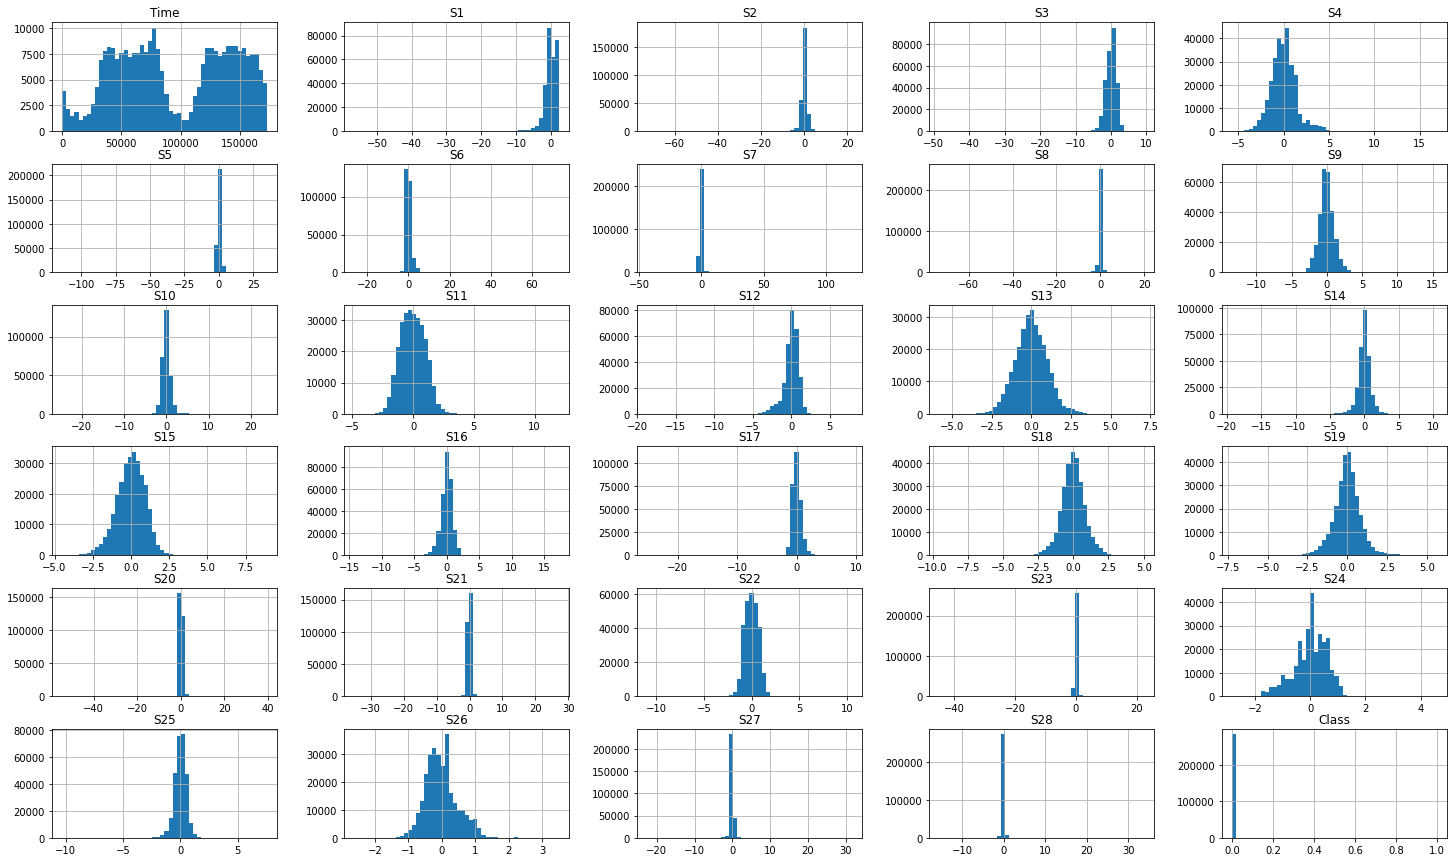

In [ ]:
data.hist(bins=50, figsize=(25,15))
plt.show()

## Creating the Feature Matrix and Labels

In [ ]:
#Splitting the data
dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].astype(int).copy()

time: 6.46 s (started: 2021-11-25 08:12:49 +00:00)
time: 97 ms (started: 2021-11-25 08:12:56 +00:00)


In [ ]:
#Checking the labels
dataY.value_counts()

0    284315
1       492
Name: Class, dtype: int64

time: 10.1 ms (started: 2021-11-25 08:12:56 +00:00)


## Feature Standardization: Rescaling the Data

Feature engineering is an inseparable aspect of ML models. In many engineering problem, we know from our tradition that combining different features significantly simplifies the problem and help us to focus our experimental / numerical work on the correct data plane. For example, we combine characteristic length, velocity, density and viscosity as Reynolds number and "classify" the flow regime in a pipe in a quite straight-forward way. The same is true on ML algorithms. You can combine features, delete the unrelated ones and rescale the data (similar to what we do in non-dimensional analysis in engineering) to help ML algorithms to seek patterns from an unbiased perspective. We will come back to this topic in the following weeks.

For the time being, lets just see how much the features are correlated. But first, we will rescale the data. It is  important to remember that most ML algorithms work better if the data is normalized around zero; that it has a mean value of zero with a standard deviation of one. Let's try it ourselves:

In [ ]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,Time,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,S22,S23,S24,S25,S26,S27,S28
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,-1.050379e-14,-1.536091e-15,-3.693350e-16,-2.082561e-15,9.153351e-16,5.854865e-18,2.784804e-16,2.636489e-16,2.820733e-16,1.465833e-16,9.990241e-17,-6.106607e-16,1.408301e-15,4.043764e-16,1.110118e-16,2.075961e-15,-9.586821e-17,3.840856e-16,3.894075e-16,-4.477913e-17,-5.225632e-16,1.308865e-16,-8.043247e-16,-6.657393e-17,1.487786e-16,-4.774076e-16,-3.018009e-16,3.521028e-17,-4.119621e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.996583e+00,-2.879855e+01,-4.403529e+01,-3.187173e+01,-4.013919e+00,-8.240810e+01,-1.963606e+01,-3.520940e+01,-6.130252e+01,-1.222802e+01,-2.258191e+01,-4.700128e+00,-1.869868e+01,-5.819392e+00,-2.004428e+01,-4.915191e+00,-1.612534e+01,-2.962645e+01,-1.133266e+01,-8.861402e+00,-7.069146e+01,-4.741907e+01,-1.506565e+01,-7.175446e+01,-4.683638e+00,-1.975033e+01,-5.401098e+00,-5.590660e+01,-4.674612e+01
25%,-8.552120e-01,-4.698918e-01,-3.624707e-01,-5.872142e-01,-5.993788e-01,-5.010686e-01,-5.766822e-01,-4.478860e-01,-1.746805e-01,-5.853631e-01,-4.917360e-01,-7.470224e-01,-4.058964e-01,-6.516198e-01,-4.439565e-01,-6.368132e-01,-5.341353e-01,-5.695609e-01,-5.951621e-01,-5.605369e-01,-2.746334e-01,-3.109433e-01,-7.473476e-01,-2.591784e-01,-5.854676e-01,-6.084001e-01,-6.780717e-01,-1.755053e-01,-1.604440e-01
50%,-2.131453e-01,9.245351e-03,3.965683e-02,1.186124e-01,-1.401724e-02,-3.936682e-02,-2.058046e-01,3.241723e-02,1.871982e-02,-4.681169e-02,-8.533551e-02,-3.209268e-02,1.401448e-01,-1.363250e-02,5.278702e-02,5.251917e-02,7.579255e-02,-7.732604e-02,-4.338370e-03,4.588014e-03,-8.104705e-02,-4.009429e-02,9.345377e-03,-1.792420e-02,6.765678e-02,3.183240e-02,-1.081217e-01,3.325174e-03,3.406368e-02
75%,9.372174e-01,6.716939e-01,4.867202e-01,6.774569e-01,5.250082e-01,4.433465e-01,2.991625e-01,4.611107e-01,2.740785e-01,5.435305e-01,4.168842e-01,7.245863e-01,6.187332e-01,6.656518e-01,5.144513e-01,7.088502e-01,5.971989e-01,4.705737e-01,5.974968e-01,5.637928e-01,1.725733e-01,2.537392e-01,7.283360e-01,2.364319e-01,7.257153e-01,6.728006e-01,4.996663e-01,2.255648e-01,2.371526e-01
max,1.642058e+00,1.253351e+00,1.335775e+01,6.187993e+00,1.191874e+01,2.521413e+01,5.502015e+01,9.747824e+01,1.675153e+01,1.419494e+01,2.180758e+01,1.177504e+01,7.854679e+00,7.160735e+00,1.098147e+01,9.699117e+00,1.976044e+01,1.089502e+01,6.014342e+00,6.869414e+00,5.113464e+01,3.703471e+01,1.447304e+01,3.607668e+01,7.569684e+00,1.442532e+01,7.293975e+00,7.831940e+01,1.025434e+02


time: 620 ms (started: 2021-11-25 08:12:56 +00:00)


As you can see, mean value is fixed as zero with a standard deviation (std) of 1. Now let's try to visualize how correlated the data is by creating a correlation matrix. 

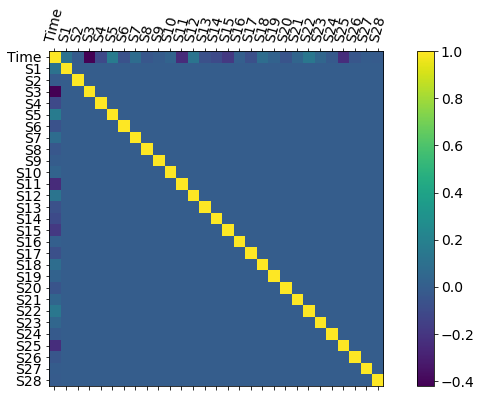

time: 1.22 s (started: 2021-11-25 08:12:56 +00:00)


In [ ]:
correlationMatrix = pd.DataFrame(dataX).corr() 

f = plt.figure(figsize=(12, 6))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(dataX.shape[1]), dataX.columns, fontsize=14, rotation=75)
plt.yticks(range(dataX.shape[1]), dataX.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [ ]:
#we can also simply look at the table via pandas:
correlationMatrix.style.background_gradient(cmap='viridis').set_precision(2)

,Time,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,S22,S23,S24,S25,S26,S27,S28
Time,1.00,0.12,-0.01,-0.42,-0.11,0.17,-0.06,0.08,-0.04,-0.01,0.03,-0.25,0.12,-0.07,-0.10,-0.18,0.01,-0.07,0.09,0.03,-0.05,0.04,0.14,0.05,-0.02,-0.23,-0.04,-0.01,-0.01
S1,0.12,1.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00
S2,-0.01,0.00,1.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00
S3,-0.42,-0.00,0.00,1.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00
S4,-0.11,-0.00,-0.00,0.00,1.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00
S5,0.17,-0.00,-0.00,-0.00,-0.00,1.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00
S6,-0.06,-0.00,0.00,-0.00,0.00,-0.00,1.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00
S7,0.08,-0.00,0.00,0.00,0.00,0.00,-0.00,1.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00
S8,-0.04,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,1.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00
S9,-0.01,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,1.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00


time: 189 ms (started: 2021-11-25 08:12:58 +00:00)


What do these numbers mean? 

When it is close to 1, it means that there is a strong positive correlation; At the other extreme; –1, it implies that there is a strong negative correlation. For more:

https://en.wikipedia.org/wiki/Correlation_and_dependence

## Preparing the Dataset for Model

We need to divide our entire dataset into fractions so that we have a training set
from which the machine learning algorithm learns. We also need another set to test the predictions of the ML algorithm. There is no golden rule here: you need to consider the size of your entire dataset. Sometimes 5% is more than enough, sometimes we need to divide 1/3 to have enough test samples. 





In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataX,
dataY, test_size=0.90,
random_state=2020, stratify=dataY)

time: 199 ms (started: 2021-11-25 08:12:58 +00:00)


Here we have frozen the randomness to make the results reproducible. Otherwise, the results would change at every run.

Note that we will use dataY only to validate the results, not to train with the algorithm as we did in supervised machine
learning problems. 

# Homogeneity in a Cluster: An Example for Self Defined Criteria

Our objective is to cluster similar cases / instances into groups so that we will generate segments based on similarities. Therefore, it is a good practice to check how similar the instances within a group via the the concept of homogeneity.

If the clustering algorithm works fine, then we would expect that the products in a given cluster are assigned the
same numerical class, which we can validate by using the numerical values stored in labels. Higher the homogeneity, better the clustering.

Note that if you do not have any labels at all, that is fine. If necessary, you can do manuel sampling and analyze the data as well. 

Lets define a function to be used later to check the similarity in clusters.

**Steps**

1.   Count the number of observations in each cluster and store these in a Pandas DataFrame called `countByCluster`

2.   Join the clusterDF with the true labels array `labelsDF`

3.   Count the number of observations for each true label `countByLabel`

4.   Count the number of observations for each distinct
label within a cluster as `countMostFreq`

5.   Store the count for the most frequently occurring number for each cluster as couples of `'cluster' ` and `'countMostFrequent'`

6.   Define the accuracy `accuracyDF` and `overallAccuracy`: here it refers to the counts of the most freq. observation in the cluster to the number of observations (how similar they are)




In [ ]:
# This function will compare the model predictions with the labels via 6 variables. 
# We will call this function after the implementation of the clustering algorithms.

def analyzeCluster(clusterDF, labelsDF):
# Here clusterDF refers to the pandas DF where the clustering algorithm predictions are stored.
#      labelsDf refers to the labels of the data we prepared above; y_train

    # Step 1: value_counts is used to return the counts of unique rows in the DataFrame['cluster'].
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    # a new sequential index is added to the DF countByCluster (0,1,2,...)
    countByCluster.reset_index(inplace=True,drop=False)
    #column labels of the given Dataframe
    countByCluster.columns = ['cluster','clusterCount']

    # Step 2: combining the true values and predicted clusters
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    #column labels of the given Dataframe
    preds.columns = ['trueLabel','cluster']

    #Step 3: Count the number of observations for each true label
    #we first group according to 'trueLabel' (in this case 0 and 1) then count the non-NaN cells.
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())

    #Step 4: Count the number of observations for each distinct label within a cluster
    #Step 5: Store the count for the most frequently occurring number for each cluster 
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg(lambda x:x.value_counts().iloc[0]))
    #index update:
    countMostFreq.reset_index(inplace=True,drop=False)
    #labeling the columns:
    countMostFreq.columns = ['cluster','countMostFrequent']

    #Step 6: Defining accuracy
    accuracyDF = countMostFreq.merge(countByCluster,left_on="cluster",right_on="cluster")
    #Overall accuracy: sum (#most freq cases) / # total instances
    overallAccuracy = accuracyDF.countMostFrequent.sum()/ accuracyDF.clusterCount.sum()
    # Accuracy by cluster:
    accuracyByLabel = accuracyDF.countMostFrequent/ accuracyDF.clusterCount

    #Return all results
    return countByCluster, countByLabel, countMostFreq, accuracyDF, overallAccuracy, accuracyByLabel  

time: 25.5 ms (started: 2021-11-25 08:12:58 +00:00)


# Kmeans Clustering

The basic idea in Kmeans is quite straight-forward:
user specifies the expected number clusters k, and the algorithm will assign each instance to one of these k clusters such that the sum of the within-cluster variations across all clusters is minimized.

At the end, we now that there two end-results: regular products and defective product. Nonetheless, there might be different groups of independent varaibles (clusters) which would lead to this global end results. Therefore, we may scan a larger number of clusters (behaviours) in the instances. 

## Inertia

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. Therefore, it requires the number of clusters to be specified.

Inertia is defined as:

$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$

where $\mu_j$ is the mean of the samples in the cluster. The means are commonly called the cluster “centroids” and they are not necessarily from the data X. 

## Important Note:

Given enough time, K-means will always converge, however this may be to a local minimum. This is highly dependent on the initialization of the centroids. One method to help address this issue is the k-means++ initialization scheme, which has been implemented in scikit-learn. This initializes the centroids to be (generally) distant from each other, leading to provably better results than random initialization.

## Kmeans with scikit learn

See the lecture notes for the model description. For the details of the implementation; see:

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html



In [ ]:
# Hyperparameters:
n_clusters = 10     # The number of clusters to form as well as the number of centroids to generate.
init = 'k-means++'  # selects initial cluster centers for k-mean clustering in a smart way!
n_init = 10         # Number of time the k-means algorithm will be run with different centroid seeds. 
                    # The final results will be the best output in terms of inertia.
max_iter = 300      # Maximum number of iterations of the k-means algorithm for a single run.
tol = 0.0001        # tolerance for two consecutive iterations to declare convergence in cluster centers. 
random_state = 2020
#n_jobs = 2         # The number of OpenMP threads to use for the computation.

#kmeans = KMeans(n_clusters=n_clusters, init = init, n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state)

time: 2.6 ms (started: 2021-11-25 08:12:58 +00:00)


Here we do not have any training. We will directly use the model. Lets say that we will try 5 to 50 clusters to segregate the data. For that purpose, we will construct a for loop:

In [ ]:
#Preparing a DF for storing kMeans inertias:
kMeans_inertia = pd.DataFrame(data=[],index=range(5,65,10), columns=['inertia'])

#Preparing a DF for storing accuracy we defined:
overallAccuracy_kMeansDF = pd.DataFrame(data=[], index=range(5,65,10),columns=['overallAccuracy'])

#Preparing a DF for storing countings by label (how many 0 and 1 is counted for each cluster):
overallAccuracy_kMeansDF = pd.DataFrame(data=[], index=range(5,65,10),columns=['overallAccuracy'])

for n_clusters in range(5,65,10):
  
  #Calling the model for a given "n_clusters" in the loop:
  kmeans = KMeans(n_clusters=n_clusters, init = init, n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state)
  
  #Compute k-means clustering with method "fit":
  kmeans.fit(X_train)

  #Saving Attribute inertia_ to the DF:
  kMeans_inertia.loc[n_clusters] = kmeans.inertia_
  
  #Predict the closest cluster each sample in X belongs to:
  X_train_kmeansClustered = kmeans.predict(X_train)

  #Creating a cluster prediction column within DF with the same indices as in X (used in performance analysis):
  X_train_kmeansClustered = pd.DataFrame(data= X_train_kmeansClustered, index=X_train.index, columns=['cluster'])

  #Using the defined function for cluster analysis:
  countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans = analyzeCluster(X_train_kmeansClustered, y_train)
  
  #Saving the overall accuracy for "n_clusters":
  overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

time: 29.6 s (started: 2021-11-25 08:12:58 +00:00)


## Observing the change in Inertia

As can be seen from below, with the increasing number of clusters, the inertia is decreasing. It is reasonable as the # cluster increases, we expect them to be more homogenous. The question is, where are we going to stop? A common exercise is to increasr the number of clusters and plot inertia vs. # cluster and to look for the 'elbow' in the plot. In our case, we do not see the elbow in the curve; maybe we can scan a higher range to have further idea. 

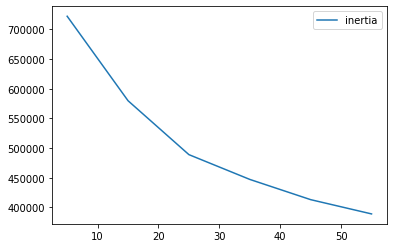

time: 188 ms (started: 2021-11-25 08:13:28 +00:00)


In [ ]:
#Plotting the inertia
kMeans_inertia.plot()

## Evaluating the overall accuracy

We have already stored the data. Lets visualize the accuracy evolution:

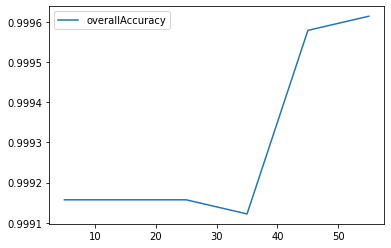

time: 186 ms (started: 2021-11-25 08:13:28 +00:00)


In [ ]:
overallAccuracy_kMeansDF.plot()

In [ ]:
accuracyByLabel_kMeans.min(axis=0)

0.8787878787878788

time: 4.05 ms (started: 2021-11-25 08:13:28 +00:00)


It looks like the accuracy approach is not well suited in this form. The error does not follow a reasonable trend.

We need to change the way we judge the quality of the results. 

## A Special Feature of the Kmeans model: "predict"

The idea behind Kmeans is to cluster the instances / examples via similarity based learning. Therefore, when the the data is processed with the method `fit`, what it does is discovering the "center of gravity" for the multi dimensional features. Therefore, we can `predict` the cluster new instances belong to by using these previously found attraction points in space. 

As an example, we can test how well our cluster centers describe the behaviour of the test data (it has not seen before).


In [ ]:
#Predict the closest cluster each sample in X belongs to:
X_test_kmeansClustered = kmeans.predict(X_test)

#Creating a cluster prediction column within DF with the same indices as in X (used in performance analysis):
X_test_kmeansClustered = pd.DataFrame(data= X_test_kmeansClustered, index=X_test.index, columns=['cluster'])

#Using the defined function for cluster analysis:
countByCluster_kMeansTest, countByLabel_kMeansTest, countMostFreq_kMeansTest, accuracyDF_kMeansTest, overallAccuracy_kMeansTest, accuracyByLabel_kMeansTest = analyzeCluster(X_test_kmeansClustered,y_test)

#Saving the overall accuracy for "n_clusters":
overallAccuracy_kMeans

0.9996137640449438

time: 212 ms (started: 2021-11-25 08:13:28 +00:00)


In [ ]:
accuracyByLabel_kMeans

0     1.000000
1     1.000000
2     1.000000
3     0.888889
4     1.000000
5     1.000000
6     0.933333
7     1.000000
8     1.000000
9     1.000000
10    1.000000
11    1.000000
12    1.000000
13    1.000000
14    1.000000
15    1.000000
16    1.000000
17    1.000000
18    0.998907
19    1.000000
20    1.000000
21    1.000000
22    1.000000
23    1.000000
24    0.993617
25    1.000000
26    1.000000
27    0.996479
28    1.000000
29    0.878788
30    1.000000
31    1.000000
32    1.000000
33    1.000000
34    1.000000
35    1.000000
36    1.000000
37    1.000000
38    1.000000
39    1.000000
40    1.000000
41    1.000000
42    1.000000
43    1.000000
44    1.000000
45    1.000000
46    1.000000
47    1.000000
48    1.000000
49    1.000000
50    1.000000
51    1.000000
52    1.000000
53    1.000000
54    1.000000
dtype: float64

time: 6.12 ms (started: 2021-11-25 08:13:28 +00:00)


In [ ]:
accuracyByLabel_kMeansTest.min(axis=0)

0.7739130434782608

time: 4.17 ms (started: 2021-11-25 08:13:28 +00:00)


As you can see, the accuracy we defined is not that different for these new instances. Nonetheless, we should revise our accuracy analysis as we can not judge whether 0.8 is a good value or a bad one. 

## Revisiting the Performance Criteria

### Built-in functions: 

There are 8 different measures available on scikit, which may be useful in your future studies:

https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

Here we will use one of them as an example.

### Silhouette Coefficient

If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (`sklearn.metrics.silhouette_score`) is an example of such an evaluation. 

$s = \frac{b - a}{max(a, b)}$

where

a: The mean distance between a sample and all other points in the same class.

b: The mean distance between a sample and all other points in the next nearest cluster.

The silhouette coefficient can vary between –1 and +1:

*   +1 >> instance is well inside its own cluster and away from others
*   +0 >> instance is near the boundary of its own cluster and close to the others
*   -1 >> instance is in the wrong cluster



In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

# The silhouette_score gives the average value for all the samples.
cluster_labels = kmeans.predict(X_train)
silhouette_avg = silhouette_score(X_train, cluster_labels)
print("The average silhouette_score is :", silhouette_avg)



The average silhouette_score is : 0.08368540202187005
time: 8.36 s (started: 2021-11-25 08:13:28 +00:00)


**Silhouette diagram**

Its visualization is possible via so called silhouette diagram, in which every instance’s
silhouette coefficient is sorted by the cluster they are assigned to and by the value of the
coefficient. 

The shape’s height indicates the number of instances
the cluster contains, and its width represents the sorted silhouette coefficients of the
instances in the cluster (wider is better). 

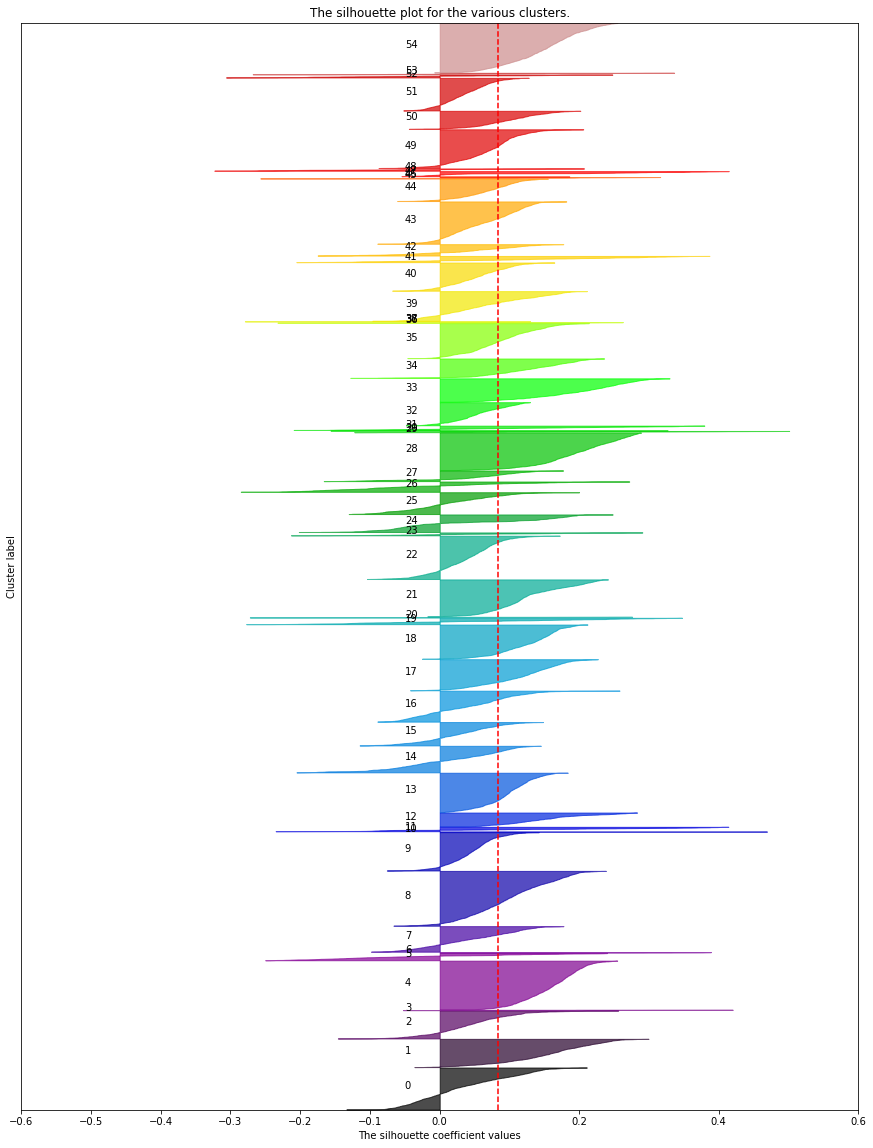

time: 8.73 s (started: 2021-11-25 08:13:37 +00:00)


In [ ]:
# Compute the silhouette scores for each sample.
# To learn more check the following link
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

range_n_clusters = [55]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 column
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(15, 20)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.6, 0.6])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_train) + (n_clusters + 1) * 10])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1, 0, 0.2, 0.4, 0.6])

## Self-Defined Function 2:

Seeing that our accuracy description is not conclusive, lets think and define a new performance criteria. The problem we are dealing with is, in principle, an outlier detection. Therefore, measuring how homogeneous our clusters are does not reflect how well isolated the outliers are. For instance, we may see that our cluster homogenities are above 98%,which look very good. However, we might distribute the outliers to different clusters so that our clustering approach fails for our objective. 

Therefore, the homogenity approach without focusing on a particular label is misleading. What we can do is the ratio of the label '1' in the clusters and check whether the outliers are segregated in certain clusters or not. 

In the below function, we will count the tags for that purpose via querry option (in combination with aggregation), which query the columns of a DataFrame with a boolean expression. In our case, boolean expression is the true label filtering for 1. Then we will count these instances for a given cluster.

`agg(lambda x:x.query('trueLabel == "1"').trueLabel.count()))`

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html



In [ ]:
# This function will compare the model predictions with the labels via 6 variables. 
# We will call this function after the implementation of the clustering algorithms.

def analyzeCluster2(clusterDF, labelsDF):
# Here clusterDF refers to the pandas DF where the clustering algorithm predictions are stored.
#      labelsDf refers to the labels of the data we prepared above; y_train

    # Step 1: value_counts is used to return the counts of unique rows in the DataFrame['cluster'].
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    # a new sequential index is added to the DF countByCluster (0,1,2,...)
    countByCluster.reset_index(inplace=True,drop=False)
    #column labels of the given Dataframe
    countByCluster.columns = ['cluster','clusterCount']

    # Step 2: combining the true values and predicted clusters
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    #column labels of the given Dataframe
    preds.columns = ['trueLabel','cluster']

    #Step 3: Count the number of observations for each true label
    #we first group according to 'trueLabel' (in this case 0 and 1) then count the non-NaN cells.
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())

    #Step 4: Count the number of observations for each distinct label within a cluster
    countTags = pd.DataFrame(data=preds.groupby('cluster').agg(lambda x:x.query('trueLabel == "1"').trueLabel.count()))

    #index update:
    countTags.reset_index(inplace=True,drop=False)
    #labeling the columns:
    countTags.columns = ['cluster','countTags']

    #Step 6: Defining accuracy
    accuracyDF = countTags.merge(countByCluster,left_on="cluster",right_on="cluster")

    # Accuracy by cluster:
    precision_1 = pd.DataFrame((accuracyDF.countTags/ accuracyDF.clusterCount).to_frame(name='Precision'))
    precision_1 = precision_1.merge(accuracyDF, left_index=True, right_index=True)

    #Return all results
    return countByLabel, precision_1  

time: 34.9 ms (started: 2021-11-25 08:13:45 +00:00)


### Testing our new function on the training set

In [ ]:
#Predict the closest cluster each sample in X belongs to:
X_train_kmeansClustered = kmeans.predict(X_train)

#Creating a cluster prediction column within DF with the same indices as in X (used in performance analysis):
X_train_kmeansClustered = pd.DataFrame(data= X_train_kmeansClustered, index=X_train.index, columns=['cluster'])

#Using the defined function for cluster analysis:
countByLabelTrain, precision_1Train = analyzeCluster2(X_train_kmeansClustered,y_train)

#Saving the overall accuracy for "n_clusters":
precision_1Train.head(3)


,Precision,cluster,countTags,clusterCount
0,0.0,0,0,1121
1,0.0,1,0,755
2,0.0,2,0,747


time: 188 ms (started: 2021-11-25 08:13:46 +00:00)


In [ ]:
precision_1Train.nlargest(5, ['Precision'],keep='first')

,Precision,cluster,countTags,clusterCount
6,0.933333,6,14,15
29,0.878788,29,29,33
3,0.111111,3,1,9
24,0.006383,24,3,470
27,0.003521,27,1,284


time: 16.7 ms (started: 2021-11-25 08:13:46 +00:00)


In [ ]:
precision_1Train.nlargest(5, ['countTags'],keep='first')

,Precision,cluster,countTags,clusterCount
29,0.878788,29,29,33
6,0.933333,6,14,15
24,0.006383,24,3,470
3,0.111111,3,1,9
18,0.001093,18,1,915


time: 17.3 ms (started: 2021-11-25 08:13:46 +00:00)


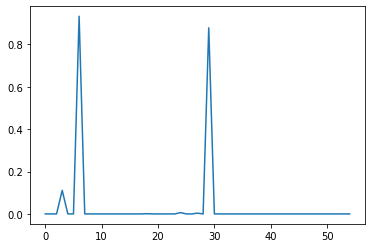

time: 155 ms (started: 2021-11-25 08:13:46 +00:00)


In [ ]:
precision_1Train['Precision'].plot()

In [ ]:
#Finding the sum of n elements in the dataframe with highest outlier number.
# In above plot / printed DF, we see that we have 2 clusters for outliers: 
n = 3
n_clustered_cases = precision_1Train.nlargest(n, ['Precision'],keep='first').countTags.sum()
print ('Number of cases clustered in ', n, ' cluster is ',n_clustered_cases)

n_total_cases = countByLabelTrain._get_value(1,'cluster')                                 
print ("The ratio to total number of anormalities is %5.2f" %(n_clustered_cases/n_total_cases*100),'%')

Number of cases clustered in  3  cluster is  44
The ratio to total number of anormalities is 89.80 %
time: 11.3 ms (started: 2021-11-25 08:13:46 +00:00)


### Testing our new function on the dataset

In [ ]:
#Predict the closest cluster each sample in X belongs to:
dataX_kmeansClustered = kmeans.predict(dataX)

#Creating a cluster prediction column within DF with the same indices as in X (used in performance analysis):
dataX_kmeansClustered = pd.DataFrame(data= dataX_kmeansClustered, index=dataX.index, columns=['cluster'])

#Using the defined function for cluster analysis:
countByLabelData, precision_1Data = analyzeCluster2(dataX_kmeansClustered,dataY)

#Saving the overall accuracy for "n_clusters":
precision_1Data.head(3)


,Precision,cluster,countTags,clusterCount
0,0.000427,0,5,11714
1,0.000000,1,0,7451
2,0.000558,2,4,7170


time: 319 ms (started: 2021-11-25 08:13:46 +00:00)


In [ ]:
precision_1Data.nlargest(5, ['Precision'],keep='first')

,Precision,cluster,countTags,clusterCount
29,0.861592,29,249,289
6,0.792308,6,103,130
3,0.059701,3,4,67
24,0.011046,24,51,4617
20,0.009756,20,2,205


time: 18.6 ms (started: 2021-11-25 08:13:46 +00:00)


In [ ]:
precision_1Data.nlargest(5, ['countTags'],keep='first')

,Precision,cluster,countTags,clusterCount
29,0.861592,29,249,289
6,0.792308,6,103,130
24,0.011046,24,51,4617
11,0.007849,11,10,1274
39,0.000863,39,7,8110


time: 19.5 ms (started: 2021-11-25 08:13:46 +00:00)


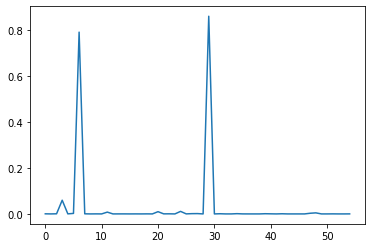

time: 204 ms (started: 2021-11-25 08:13:46 +00:00)


In [ ]:
precision_1Data['Precision'].plot()

In [ ]:
#Finding the sum of n elements in the dataframe with highest outlier number.
# In above plot / printed DF, we see that we have 3 clusters for outliers: 
n = 3
n_clustered_cases = precision_1Data.nlargest(n, ['Precision'],keep='first').countTags.sum()
print ('Number of cases clustered in ', n, ' cluster is ',n_clustered_cases)

n_total_cases = countByLabelData._get_value(1,'cluster')                                 
print ("The ratio to total number of anormalities is %5.2f" %(n_clustered_cases/n_total_cases*100),'%')

Number of cases clustered in  3  cluster is  356
The ratio to total number of anormalities is 72.36 %
time: 9.86 ms (started: 2021-11-25 08:13:47 +00:00)


# Hierarchical Clustering

Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering

This is a bottom-up approach. In other owrds, at the beginning, each data point is treated as a cluster (N). Then, algorithm combines the closest two point, leading to (N-1) clusters. Once a single cluster is formed, dendrograms are used to divide the data into desired number of clusters.

Here the question is how we are going to measure the similarity. For that purpose, different distance definitions are used such as Euclidean, Minkowski or Manhattan. 


## Re-sizing the Dataset for Model: Memory Limitations

If you uncomment data rescaling below and try ato to run the hierarchical clustering, you would see that session will crash after using all available RAM. This is a typical problem with HC (memory scaling with data size). Try and see! 

As a solution, you can create a sub-sample from the data and run the model with much less data, which is what we will do below. Alternatively, you can try the reduce the dimensions of the dataset (we will see next week) or use a connectivity matrix.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataX,
dataY, test_size=0.9,
random_state=2020, stratify=dataY)

time: 155 ms (started: 2021-11-25 08:13:47 +00:00)


Here we have frozen the randomness to make the results reproducible. Otherwise, the results would change at every run.

Note that we will use dataY only to validate the results, not to train with the algorithm as we did in supervised machine
learning problems. 

## Model Implementation

In [ ]:
# Hyperparameters:

n_clusters=20           # The number of clusters to find.
affinity = 'euclidean'  # If linkage is “ward”, only “euclidean” is accepted.
linkage='ward'          # ward minimizes the variance of the clusters being merged.

AggCluster = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)


time: 3.12 ms (started: 2021-11-25 08:13:47 +00:00)


In [ ]:
#Predict the closest cluster each sample in X belongs to:
X_train_AggClusterClustered = AggCluster.fit_predict(X_train)

time: 51.1 s (started: 2021-11-25 08:13:47 +00:00)


In [ ]:
X_train_AggClusterClustered

array([ 2, 19, 11, ..., 15, 11,  2])

time: 4.42 ms (started: 2021-11-25 08:14:38 +00:00)


In [ ]:
#Creating a cluster prediction column within DF with the same indices as in X (used in performance analysis):
X_train_AggClusterClusteredDF = pd.DataFrame(data= X_train_AggClusterClustered, index=X_train.index, columns=['cluster'])
X_train_AggClusterClusteredDF

,cluster
181469,2
168039,19
39867,11
118760,17
218072,17
...,...
11689,15
22524,16
154971,15
115598,11


time: 16.8 ms (started: 2021-11-25 08:14:38 +00:00)


## Scikit Learn Evaluation Criteria

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

# The silhouette_score gives the average value for all the samples.
silhouette_avg = silhouette_score(X_train, X_train_AggClusterClustered)
print("The average silhouette_score is :", silhouette_avg)



The average silhouette_score is : 0.06313725147017887
time: 8.16 s (started: 2021-11-25 08:14:38 +00:00)


**Silhouette diagram**

Its visualization is possible via so called silhouette diagram, in which every instance’s
silhouette coefficient is sorted by the cluster they are assigned to and by the value of the
coefficient. 

The shape’s height indicates the number of instances
the cluster contains, and its width represents the sorted silhouette coefficients of the
instances in the cluster (wider is better). 

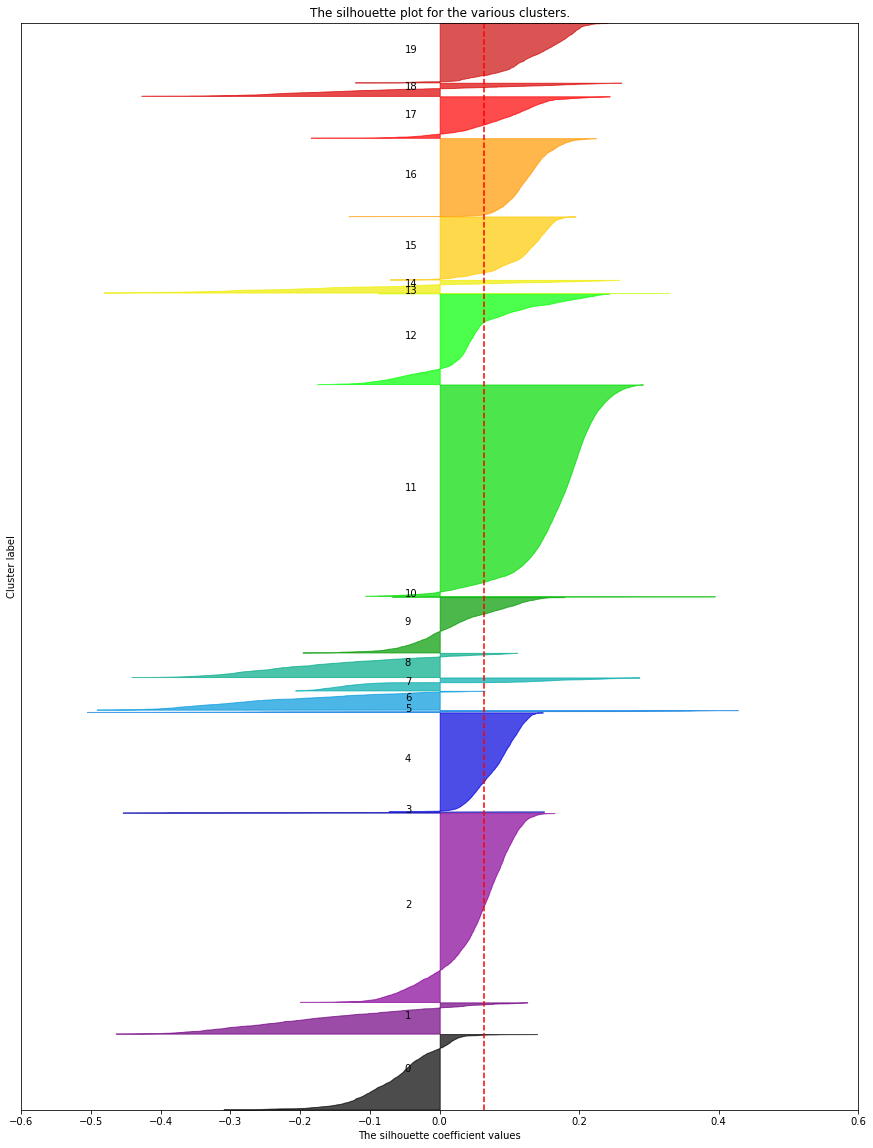

time: 8.67 s (started: 2021-11-25 08:14:46 +00:00)


In [ ]:
# Compute the silhouette scores for each sample.
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

range_n_clusters = [20]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 column
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(15, 20)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.6, 0.6])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_train) + (n_clusters + 1) * 10])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train, X_train_AggClusterClustered)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[X_train_AggClusterClustered == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1, 0, 0.2, 0.4, 0.6])

### Testing our new function on the training set

In [ ]:
#Using the defined function for cluster analysis:
countByLabelTrainHC, precision_1TrainHC = analyzeCluster2(X_train_AggClusterClusteredDF,y_train)

#Saving the overall accuracy for "n_clusters":
precision_1TrainHC.head(3)


,Precision,cluster,countTags,clusterCount
0,0.0,0,0,1990
1,0.0,1,0,826
2,0.0,2,0,4986


time: 88.9 ms (started: 2021-11-25 08:14:55 +00:00)


In [ ]:
precision_1TrainHC.nlargest(5, ['Precision'],keep='first')

,Precision,cluster,countTags,clusterCount
5,0.862745,5,44,51
10,0.200000,10,2,10
12,0.000838,12,2,2388
15,0.000601,15,1,1664
0,0.000000,0,0,1990


time: 15.2 ms (started: 2021-11-25 08:14:55 +00:00)


In [ ]:
precision_1TrainHC.nlargest(5, ['countTags'],keep='first')

,Precision,cluster,countTags,clusterCount
5,0.862745,5,44,51
10,0.200000,10,2,10
12,0.000838,12,2,2388
15,0.000601,15,1,1664
0,0.000000,0,0,1990


time: 17.1 ms (started: 2021-11-25 08:14:55 +00:00)


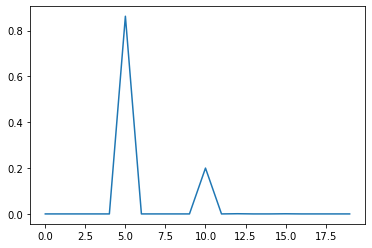

time: 175 ms (started: 2021-11-25 08:14:55 +00:00)


In [ ]:
precision_1TrainHC['Precision'].plot()

In [ ]:
#Finding the sum of n elements in the dataframe with highest outlier number.
# In above plot / printed DF, we see that we have 1 cluster for outliers: 
n = 1
n_clustered_cases = precision_1TrainHC.nlargest(n, ['Precision'],keep='first').countTags.sum()
print ('Number of cases clustered in ', n, ' cluster is ',n_clustered_cases)

n_total_cases = countByLabelTrainHC._get_value(1,'cluster')                                 
print ("The ratio to total number of anormalities is %5.2f" %(n_clustered_cases/n_total_cases*100),'%')

Number of cases clustered in  1  cluster is  44
The ratio to total number of anormalities is 89.80 %
time: 9.5 ms (started: 2021-11-25 08:14:55 +00:00)


# An Alternative SciPy Library for Hierarchical Clustering

`fcluster` library from SciPy is a better / faster alternative for scikit learn lib used above. Note that in this model, we need to specify the distance threshold of the dendrogram to determine how many distinct clusters we are left with (similar to `distance_threshold` of scikit).

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

The linkage() function will use the selected method and metric to calculate the distances of the clusters (starting with the data points as singleton clusters).  At each iteration, it will merge the two clusters which have the smallest distance (according the selected method and metric). 

Initially, the algorithm is just merging single-point clusters together, but as it proceeds, it will merge multipoint clusters with either single-point or multipoint clusters. Eventually, through this iterative process, all the clusters are merged together, forming the trunk in the upside-down tree (dendrogram).

In [ ]:
#Here we will calculate Z:
from scipy.cluster.hierarchy import fcluster, linkage
Z = linkage(X_train, method='ward', metric='euclidean')

time: 48.6 s (started: 2021-11-25 08:14:55 +00:00)


`Z[i]` will tell us which clusters were merged in the i-th iteration:

In [ ]:
Z[0]

array([2.6496e+04, 2.6665e+04, 0.0000e+00, 2.0000e+00])

time: 4.23 ms (started: 2021-11-25 08:15:44 +00:00)


In [ ]:
Z[20000]

array([4.05630000e+04, 4.30870000e+04, 3.42155373e+00, 8.00000000e+00])

time: 3.68 ms (started: 2021-11-25 08:15:44 +00:00)


Here the `Z[i]` has the format of `[Cluster id 1, Cluster id 2, distance, new cluster size]`.

Let's have a look at 10 iterations. Here you can see that the distances are gradually increasing (3rd column).

In [ ]:
Z[20000:20010]

array([[4.05630000e+04, 4.30870000e+04, 3.42155373e+00, 8.00000000e+00],
       [7.35200000e+03, 1.85750000e+04, 3.42185889e+00, 2.00000000e+00],
       [2.68080000e+04, 4.76160000e+04, 3.42216320e+00, 6.00000000e+00],
       [3.80060000e+04, 4.64860000e+04, 3.42222835e+00, 7.00000000e+00],
       [4.33940000e+04, 4.51030000e+04, 3.42244705e+00, 1.20000000e+01],
       [4.46710000e+04, 4.55840000e+04, 3.42257077e+00, 1.40000000e+01],
       [4.20360000e+04, 4.76540000e+04, 3.42259637e+00, 1.60000000e+01],
       [4.54520000e+04, 4.70560000e+04, 3.42270842e+00, 7.00000000e+00],
       [2.21780000e+04, 4.25910000e+04, 3.42273126e+00, 5.00000000e+00],
       [1.02780000e+04, 4.19830000e+04, 3.42383286e+00, 6.00000000e+00]])

time: 4.53 ms (started: 2021-11-25 08:15:44 +00:00)


Note:

`cophenet()` function compares the actual pairwise distances of all your samples to those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances. See:

https://en.wikipedia.org/wiki/Cophenetic_correlation

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.cophenet.html


In [ ]:
#c, coph_dists = cophenet(Z, pdist(X_train))
#c

time: 901 µs (started: 2021-11-25 08:15:44 +00:00)


## Plotting a Dendrogram

A dendrogram is a visualization in form of a tree showing the order and distances of merges during the hierarchical clustering.


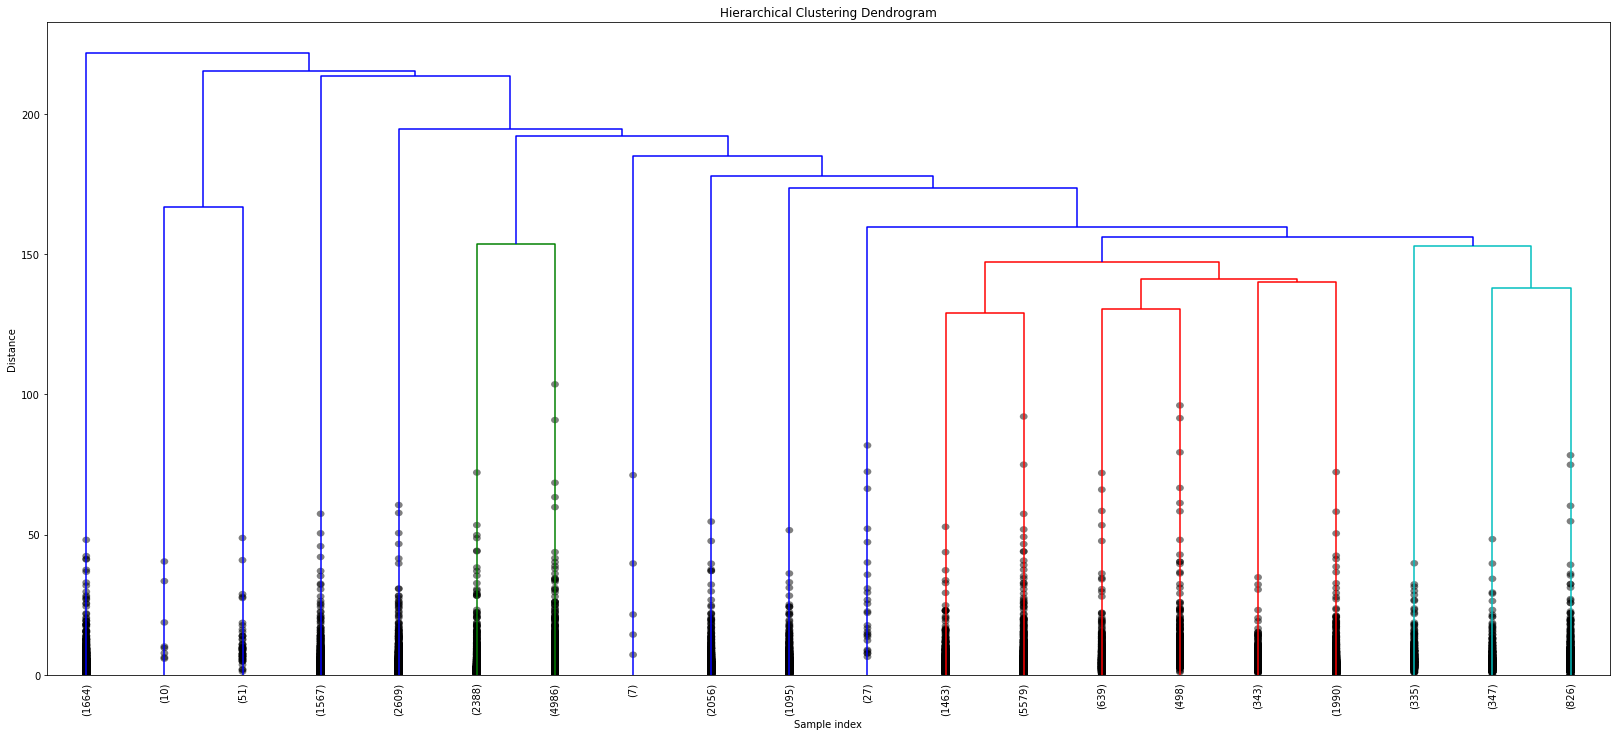

time: 25.6 s (started: 2021-11-25 08:15:44 +00:00)


In [ ]:
# calculate full dendrogram
plt.figure(figsize=(28, 12))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    show_contracted=True  # to get a distribution impression in truncated branches
)
plt.show()



Here the x axis refers to the indices of the data X. y axis demonstrates the distance calculated by `ward` method. The heights of the horizontal lines tell you about the distance that needed to be "bridged" to form the new cluster.  

The parameter` show_contracted` draws black dots at the heights of those previous cluster merges. This is important as we can still identify how different these clusters are before they merge through the distance at which they are merged, even if we did not plot the entire reverse tree.

In our example we can see that around 20, the differences between classes are reasonable high before the next merge. However, if we had reduced the data into two classes, they would be too similar for an outlier detection. 

## Selecting the Cutoff Point

There is another alternative library requiring much less memory:

https://cran.r-project.org/web/packages/fastcluster/vignettes/fastcluster.pdf

https://pypi.org/project/fastcluster/



In [ ]:
np.version.version

'1.21.4'

time: 6.53 ms (started: 2021-11-25 08:16:09 +00:00)


In [ ]:
#!pip install fastcluster: no longer needed. note that fast cluster requires the new version of numpy. This is why we reinstalled
!pip install fastcluster
# it at the very beginning. 
import fastcluster

Z = fastcluster.linkage_vector(X_train, method='ward', metric='euclidean')

     |████████████████████████████████| 155 kB 36.6 MB/s 
time: 32.9 s (started: 2021-11-25 08:21:04 +00:00)


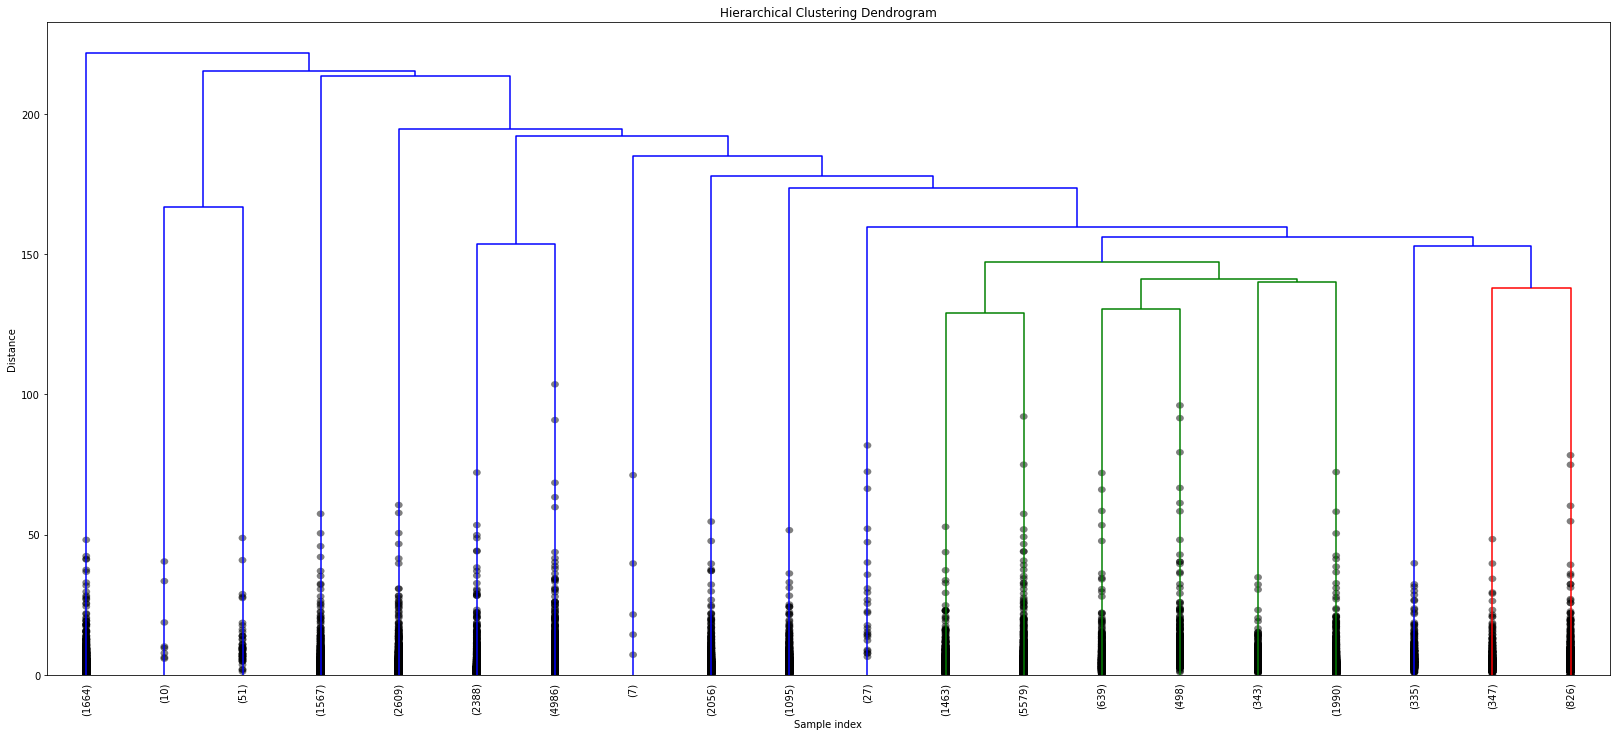

time: 25.6 s (started: 2021-11-25 08:29:56 +00:00)


In [ ]:
# calculate full dendrogram
plt.figure(figsize=(28, 12))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    color_threshold = 150, #Colors all the descendent links below a cluster node the same color if is the first node below the cut threshold.
    show_contracted=True  # to get a distribution impression in truncated branches
)
plt.show()

## Generating Clusters

Next step is to create the clusters from the dendrogram via `fcluster`. There we will use a distance threshold value to determine the number of clusters left.

In [ ]:
distance_threshold = 80
clusters = fcluster(Z, distance_threshold, criterion ='distance')
X_train_HierarClustered = pd.DataFrame(data= clusters, index=X_train.index, columns=['cluster'])

time: 89.6 ms (started: 2021-11-25 08:30:23 +00:00)


In [ ]:
print('# Clusters:', len(X_train_HierarClustered['cluster'].unique()))

# Clusters: 40
time: 5.3 ms (started: 2021-11-25 08:30:23 +00:00)


## Testing our new function on the training set

In [ ]:
#Using the defined function for cluster analysis:
countByLabelTrainHC2, precision_1TrainHC2 = analyzeCluster2(X_train_HierarClustered,y_train)

#Saving the overall accuracy for "n_clusters":
precision_1TrainHC2.head(3)


,Precision,cluster,countTags,clusterCount
0,0.000601,1,1,1664
1,1.000000,2,2,2
2,0.000000,3,0,8


time: 131 ms (started: 2021-11-25 08:30:23 +00:00)


In [ ]:
precision_1TrainHC2.nlargest(5, ['Precision'],keep='first')

,Precision,cluster,countTags,clusterCount
1,1.000000,2,2,2
3,0.928571,4,13,14
4,0.837838,5,31,37
8,0.002924,9,1,342
0,0.000601,1,1,1664


time: 21.8 ms (started: 2021-11-25 08:30:23 +00:00)


In [ ]:
precision_1TrainHC2.nlargest(5, ['countTags'],keep='first')

,Precision,cluster,countTags,clusterCount
4,0.837838,5,31,37
3,0.928571,4,13,14
1,1.000000,2,2,2
0,0.000601,1,1,1664
8,0.002924,9,1,342


time: 16.6 ms (started: 2021-11-25 08:30:23 +00:00)


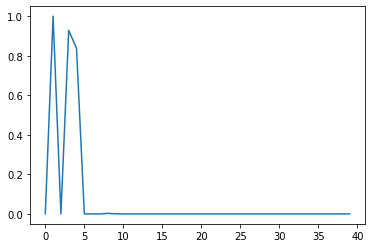

time: 183 ms (started: 2021-11-25 08:30:23 +00:00)


In [ ]:
precision_1TrainHC2['Precision'].plot()

In [ ]:
#Finding the sum of n elements in the dataframe with highest outlier number.
# In above plot / printed DF, we see that we have 3 clusters for outliers: 
n = 3
n_clustered_cases = precision_1TrainHC2.nlargest(n, ['Precision'],keep='first').countTags.sum()
print ('Number of cases clustered in ', n, ' cluster is ',n_clustered_cases)

n_total_cases = countByLabelTrainHC2._get_value(1,'cluster')                                 
print ("The ratio to total number of anormalities is %5.2f" %(n_clustered_cases/n_total_cases*100),'%')

Number of cases clustered in  3  cluster is  46
The ratio to total number of anormalities is 93.88 %
time: 13.1 ms (started: 2021-11-25 08:30:23 +00:00)


# DBSCAN: Density-based spatial clustering of applications with noise

DBSCAN will group together closely packed points, where close together is defined as a minimum number of points that must exist within a certian distance.
If the point is within a certain distance of multiple clusters, it will be grouped with the cluster to which it is most densely located. Any instance that is not within this certain distance of another cluster is labeled an outlier. 

The algorithm defines clusters as continuous regions of high density. There are two parameters to the algorithm, `min_samples` and `eps`, which define formally what we mean when we say dense. Higher `min_samples` or lower `eps` indicate higher density necessary to form a cluster. While the parameter `min_samples` primarily controls how tolerant the algorithm is towards noise (on noisy and large data sets it may be desirable to increase this parameter), the parameter `eps` is crucial to choose appropriately for the data set and distance function and usually cannot be left at the default value. 

https://scikit-learn.org/stable/modules/clustering.html#dbscan


In short, the algorithm work as follows:

1. counts how many instances are located within a
small distance `eps` from it for each instance. #

2. If an instance has at least `min_samples` instances in its `eps` neighborhood, then it is considered a **core instance**.

3. All instances in the neighborhood of a core instance belong to the same cluster.

4. Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.

Lets implement the method for our dataset.

In [ ]:
# Hyperparameters:
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
#
eps=7                # The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
min_samples=2        # The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
                     # This includes the point itself.
metric='euclidean'   # metric to use when calculating distance between instances in a feature array. 
algorithm='auto'     # The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors. 
                     # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}
leaf_size=30         # Leaf size passed to BallTree or cKDTree.  The optimal value depends on the nature of the problem.

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=algorithm,leaf_size=leaf_size)

time: 6.47 ms (started: 2021-11-25 08:30:23 +00:00)


In [ ]:
#Predict the closest cluster each sample in X belongs to:

X_train_DBSCAN = dbscan.fit_predict(X_train)

time: 16.4 s (started: 2021-11-25 08:30:23 +00:00)


In [ ]:
#Creating a cluster prediction column within DF with the same indices as in X (used in performance analysis):
X_train_DBSSCANDF = pd.DataFrame(data= X_train_DBSCAN, index=X_train.index, columns=['cluster'])
X_train_DBSSCANDF

,cluster
181469,0
168039,0
39867,0
118760,0
218072,0
...,...
11689,0
22524,0
154971,0
115598,0


time: 17.1 ms (started: 2021-11-25 08:30:40 +00:00)


In [ ]:
#Using the defined function for cluster analysis:
countByLabelTrainDBSCAN, precision_1TrainDBSCAN = analyzeCluster2(X_train_DBSSCANDF,y_train)

#Saving the overall accuracy for "n_clusters":
precision_1TrainDBSCAN.head(3)


,Precision,cluster,countTags,clusterCount
0,0.103896,-1,16,154
1,0.000106,0,3,28245
2,0.750000,1,15,20


time: 88.5 ms (started: 2021-11-25 08:30:40 +00:00)


Notice that some instances have a cluster index equal to –1, which means that they
are considered as anomalies by the algorithm. 

The default value for `eps` is 0.5, and the default
value for `min_samples` is 5. If `eps` is set too low, no points may be close enough
to other points for them to be considered in the same neighborhood. Hence, all
the points would remain unclustered.

In [ ]:
precision_1TrainDBSCAN.nlargest(10, ['Precision'],keep='first')

,Precision,cluster,countTags,clusterCount
3,1.000000,2,2,2
13,1.000000,12,5,5
14,1.000000,13,2,2
16,1.000000,15,2,2
7,0.800000,6,4,5
2,0.750000,1,15,20
0,0.103896,-1,16,154
1,0.000106,0,3,28245
4,0.000000,3,0,3
5,0.000000,4,0,2


time: 17.5 ms (started: 2021-11-25 08:30:40 +00:00)


In [ ]:
precision_1TrainDBSCAN.nlargest(5, ['countTags'],keep='first')

,Precision,cluster,countTags,clusterCount
0,0.103896,-1,16,154
2,0.750000,1,15,20
13,1.000000,12,5,5
7,0.800000,6,4,5
1,0.000106,0,3,28245


time: 27.5 ms (started: 2021-11-25 08:30:40 +00:00)


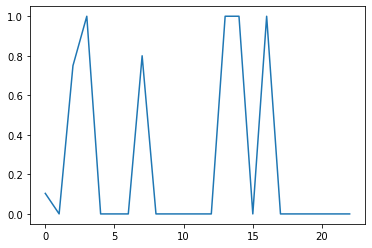

time: 188 ms (started: 2021-11-25 08:30:40 +00:00)


In [ ]:
precision_1TrainDBSCAN['Precision'].plot()

In [ ]:
#Finding the sum of n elements in the dataframe with highest outlier number.
# In above plot / printed DF, we see that we have several clusters for outliers: 
n = 6
n_clustered_cases = precision_1TrainDBSCAN.nlargest(n, ['Precision'],keep='first').countTags.sum()
print ('Number of cases clustered in ', n, ' cluster is ',n_clustered_cases)

n_total_cases = countByLabelTrainDBSCAN._get_value(1,'cluster')                                 
print ("The ratio to total number of anomalities is %5.2f" %(n_clustered_cases/n_total_cases*100),'%')

Number of cases clustered in  6  cluster is  30
The ratio to total number of anomalities is 61.22 %
time: 10.6 ms (started: 2021-11-25 08:30:40 +00:00)


To  **further increase the precision**, we must do a **grid search** on the hyper parameters. 

# Mixture Models: Bayesian Gaussian Mixture

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. In other words, like k-means and hierarchical clustering, the GMM model requires the specification of the number of mixtures k and the individual statistical properties of each mixture that best fit the data.

What does it mean in practice? GMMs are especially useful since it can be completely characterized by two parameters: the mean and the variance and we can analyze the confidence in our estimations.

The `BayesianGaussianMixture` object implements a variant of the Gaussian mixture model with variational inference algorithms. The API is similar as the one defined by `GaussianMixture`. Its estimation algorithm is the  variational inference,  The principle behind variational methods is the same as expectation-maximization, but variational methods add regularization by integrating information from prior distributions. 

In the model, you can use the `predict()` method for hard clustering, or the `predict_proba()` method for soft clustering.

https://scikit-learn.org/stable/modules/mixture.html

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html

**Important note:**

Like K-Means, GMM can end up converging to poor solutions, so it needs to be run several times, keeping only the best solution.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataX,
dataY, test_size=0.96,
random_state=2020, stratify=dataY)

time: 155 ms (started: 2021-11-25 08:30:40 +00:00)


In [ ]:
# Hyperparameters:
#https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html

#The number of mixture components:
n_components = 50
# covariance_type{‘full’, ‘tied’, ‘diag’, ‘spherical’}, defaults to ‘full’
covariance_type = 'full'
#The convergence threshold:
tol = 0.0001  
#The number of initializations to perform:
n_init = 10
#init_params{‘kmeans’, ‘random’}, The method used to initialize the weights, the means and the covariances. 
init_params = 'kmeans'
random_state = 2020
# Model Definition:
bgm = BayesianGaussianMixture(n_components=n_components, covariance_type = covariance_type, tol=tol, n_init=n_init, init_params=init_params, random_state=random_state)

time: 8.29 ms (started: 2021-11-25 08:30:40 +00:00)


In [ ]:
# Model fitting:
bgm.fit(X_train)

BayesianGaussianMixture(n_components=50, n_init=10, random_state=2020,
                        tol=0.0001)

time: 8min 19s (started: 2021-11-25 08:30:41 +00:00)


In [ ]:
# Hard clustering: It will only provide you the cluster labels (similar to other methods)
X_train_bgm_h = bgm.predict(X_train)

time: 638 ms (started: 2021-11-25 08:39:00 +00:00)


In [ ]:
#Creating a cluster prediction column within DF with the same indices as in X (used in performance analysis):
X_train_hbgm_DF = pd.DataFrame(data= X_train_bgm_h, index=X_train.index,columns=['cluster'])
X_train_hbgm_DF.sample(3)

,cluster
158078,21
151183,14
256836,40


time: 27.2 ms (started: 2021-11-25 08:39:01 +00:00)


In [ ]:
#Looking into weights:
# Remember that bgm gives weights equal (or close) to zero to unnecessary clusters.
# Lets say that we cut the weights after three digits:
weights = pd.Series(np.round(bgm.weights_, 3))
# Now we can see how many non-zero clusters are found. Remember: we run the model with 50 clusters!
print('Number of filtered cluster is ~',len(weights.unique()))

Number of filtered cluster is ~ 24
time: 6.68 ms (started: 2021-11-25 08:39:01 +00:00)


In [ ]:
# Soft clustering: This method will give us the probabilities of an instance to 
# belong to all 50 clusters we modelled. It is also possible to filter
# the 25 clusters with sufficient weights and then perform the prob. analysis.
X_train_bgm_s = bgm.predict_proba(X_train)

time: 276 ms (started: 2021-11-25 08:39:01 +00:00)


In [ ]:
#Creating a cluster prediction column within DF with the same indices as in X:
X_train_sbgm_DF = pd.DataFrame(data= X_train_bgm_s, index=X_train.index)
X_train_sbgm_DF.sample(3)
# Below you will see the prob. distribution for various clusters for 3 instances.
# As an exercise, you can plot the probability distributions for a given instance.

# Hint: If you have up to 3 dimensions or reduced the dimensions of the system (we will learn next week),
# you can also visualize the confidence in the cluster coundaries.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
179854,1.385705e-59,1.000000e+00,0.0,0.0,2.976027e-119,5.360071e-110,2.270689e-206,4.848192e-233,5.728734e-99,4.751150e-179,3.555296e-69,5.180743e-55,1.694804e-176,6.812205e-99,2.481298e-53,1.707115e-36,6.832519e-102,4.292180e-32,4.818713e-132,0.000000e+00,1.650643e-73,4.112676e-112,1.422579e-49,1.336538e-71,4.939664e-106,2.662613e-79,8.284131e-109,7.278811e-94,5.263521e-85,1.199997e-146,5.473923e-68,1.192832e-70,7.749575e-97,7.104320e-99,4.603139e-104,1.847159e-60,7.850751e-96,7.689494e-254,9.251240e-69,2.248164e-105,0.0,3.647035e-61,2.661652e-21,0.0,2.055905e-276,5.300835e-197,6.690696e-99,1.016940e-49,9.719881e-109,2.906310e-67
229828,6.095517e-58,0.000000e+00,0.0,0.0,2.755890e-107,1.118075e-129,9.118484e-54,1.392932e-232,2.983477e-107,2.970885e-272,5.690123e-112,0.000000e+00,0.000000e+00,1.687124e-118,2.158992e-240,8.850022e-47,1.733384e-110,5.524944e-43,0.000000e+00,0.000000e+00,4.194609e-125,3.841034e-91,0.000000e+00,5.171931e-167,4.377815e-114,2.299498e-109,1.442735e-119,6.377468e-104,6.091141e-67,2.136953e-144,3.814288e-122,0.000000e+00,2.576677e-102,3.162276e-107,1.133335e-116,1.927691e-202,6.284841e-104,0.000000e+00,6.541902e-308,1.284441e-112,1.0,3.060150e-165,7.146002e-82,0.0,4.645420e-275,2.272005e-199,3.632082e-107,0.000000e+00,1.054816e-76,6.246103e-140
235039,2.612689e-55,3.883783e-181,0.0,0.0,5.200285e-182,3.747781e-251,0.000000e+00,0.000000e+00,1.008848e-222,0.000000e+00,2.515284e-222,2.386562e-194,0.000000e+00,1.570194e-160,1.108668e-103,6.925998e-96,4.145033e-230,2.796549e-34,0.000000e+00,4.483457e-193,2.104049e-162,4.632221e-91,5.289953e-37,6.482128e-41,4.736356e-234,7.805538e-149,4.525543e-202,1.286705e-93,2.130572e-237,4.755741e-178,6.001793e-134,2.210194e-70,1.418749e-223,7.640613e-223,5.284340e-178,0.000000e+00,1.721090e-215,4.027131e-144,3.367253e-74,1.167691e-223,1.0,1.174859e-259,1.205329e-25,0.0,0.000000e+00,0.000000e+00,6.983185e-223,5.205969e-277,5.420221e-109,5.243874e-104


time: 115 ms (started: 2021-11-25 08:39:01 +00:00)


In [ ]:
#Using the defined function for cluster analysis: Note that we will use the results of hard clustering (decisions):
countByLabelTrainBgm, precision_1TrainBgm = analyzeCluster2(X_train_hbgm_DF,y_train)


time: 131 ms (started: 2021-11-25 08:39:01 +00:00)


In [ ]:
# List of 10 clusters with the largest precision values:
precision_1TrainBgm.nlargest(10, ['Precision'],keep='first')

,Precision,cluster,countTags,clusterCount
5,0.875000,5,7,8
20,0.833333,20,10,12
23,0.054054,23,2,37
46,0.001087,47,1,920
0,0.000000,0,0,114
1,0.000000,1,0,324
2,0.000000,2,0,1371
3,0.000000,3,0,1699
4,0.000000,4,0,19
6,0.000000,6,0,179


time: 21.1 ms (started: 2021-11-25 08:39:02 +00:00)


In [ ]:
# List of 10 clusters with the largest number of anomalies:
precision_1TrainBgm.nlargest(5, ['countTags'],keep='first')

,Precision,cluster,countTags,clusterCount
20,0.833333,20,10,12
5,0.875000,5,7,8
23,0.054054,23,2,37
46,0.001087,47,1,920
0,0.000000,0,0,114


time: 18.5 ms (started: 2021-11-25 08:39:02 +00:00)


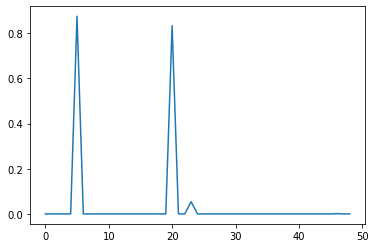

time: 168 ms (started: 2021-11-25 08:39:02 +00:00)


In [ ]:
#Plotting the variation of precision among clusters:
precision_1TrainBgm['Precision'].plot()

In [ ]:
#Finding the sum of n elements in the dataframe with highest outlier number.
# In above plot / printed DF, we see that we have 2 clusters for outliers: 
n = 2
n_clustered_cases = precision_1TrainBgm.nlargest(n, ['Precision'],keep='first').countTags.sum()
print ('Number of cases clustered in ', n, ' cluster is ',n_clustered_cases)

n_total_cases = countByLabelTrainBgm._get_value(1,'cluster')                                 
print ("The ratio to total number of anomalities is %5.2f" %(n_clustered_cases/n_total_cases*100),'%')

Number of cases clustered in  2  cluster is  17
The ratio to total number of anomalities is 85.00 %
time: 8.59 ms (started: 2021-11-25 08:39:02 +00:00)


## Score_samples() as a filter:

It is also possible to estimate the density of the model at any given location. This is
achieved using the `score_samples()` method:

In [ ]:
densities = bgm.score_samples(X_train)
# Density threshold value = 10%:
density_threshold = np.percentile(densities, 10.0)

time: 270 ms (started: 2021-11-25 08:39:02 +00:00)


In [ ]:
# Creating a filter for anomalies. We are assuming that anomalies do not form a cluster
# but lies in the far outer regions of the clusters (low density regions):
y_anomaly = y_train[densities < density_threshold]
print('Number of anomalies is found as', len(y_anomaly))

Number of anomalies is found as 1140
time: 16.3 ms (started: 2021-11-25 08:39:02 +00:00)


In [ ]:
# We have found 1140 anomalies for 10% threshold. Lets see whether they are really anomalies or not:
output_valueCounts = y_anomaly.value_counts() 
output_valueCounts

0    1127
1      13
Name: Class, dtype: int64

time: 18 ms (started: 2021-11-25 08:39:02 +00:00)


In [ ]:
# As you can see above, we only captured 13 anomalies while 1127 cases were labelled wrong.
# Lets see the true values:
trueLabelCounts = y_train.value_counts()
trueLabelCounts

0    11372
1       20
Name: Class, dtype: int64

time: 11.9 ms (started: 2021-11-25 08:39:02 +00:00)


In [ ]:
#Calculate precision from the true values and density-based predictions:
print ("Precision of the value_counts approach is %5.2f" %(output_valueCounts[1]/(output_valueCounts[0]+output_valueCounts[1])*100),'%')

Precision of the value_counts approach is  1.14 %
time: 3.8 ms (started: 2021-11-25 08:39:02 +00:00)


In [ ]:
#Calculate recall from the true values and density-based predictions:
print ("Recall of the value_counts approach is %5.2f" %(output_valueCounts[1]/(trueLabelCounts[1])*100),'%')

Recall of the value_counts approach is 65.00 %
time: 2.71 ms (started: 2021-11-25 08:39:02 +00:00)


As you can see, we have a very poor precision, as well as recall if we rely on the density based anomaly detection. In this database, this approach fails as our outliers are not generated as anomalies emerged from the same physics (like a measurement noise), but are the results of a process. Hence, they are expected to be a anomaly class rather than individual anomalies (like a noise). 

Therefore, density based filtering is good to know and may be helpful to you in your own research! 

GMM  is a generative model, hence you can sample new
instances from it via `sample` method:

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html#sklearn.mixture.BayesianGaussianMixture.sample


# Reading Material

https://scikit-learn.org/stable/modules/clustering.html

https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/

https://scikit-learn.org/stable/auto_examples/cluster/plot_inductive_clustering.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html

http://www.cs.ucr.edu/~eamonn/meaningless.pdf

http://amid.fish/anomaly-detection-with-k-means-clustering

https://github.com/LeeDoYup/Anomaly-Detection-with-K-means

https://developers.google.com/machine-learning/clustering/

https://developers.google.com/machine-learning/clustering/clustering-algorithms



# Futher Notes

You may also want to try Hierarchical DBSCAN (HDBSCAN), a recent algorithm developed by some of the same people who write the original DBSCAN paper.

https://hdbscan.readthedocs.io/en/latest/
